<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/Insomnia_ARIMA_Predictions%20with%20COMMENTS%20NK_4_25_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team Insomnia - Stock Prediction

# Imports

In [1]:
#Install statsmodels to get ARIMA
!pip install statsmodels
#Install pmdarima to get auto ARIMA
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA       #ARIMA model
from pmdarima import auto_arima #Auto ARIMA
import matplotlib.pyplot as plt                     # ploting Graphs
from statsmodels.graphics.tsaplots import plot_acf  # ploting more Graphs
from pmdarima.arima.utils import ndiffs             # for ndiffs evaluation
from statsmodels.graphics.tsaplots import plot_pacf # parcial graphs



In [4]:
#Mount drive to get Huge Stock Market Data Text Files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Data from Files

In [44]:
#declare filenames
adm_file_path = '/content/drive/MyDrive/adm.us.txt'
msi_file_path = '/content/drive/MyDrive/msi.us.txt'
xom_file_path = '/content/drive/MyDrive/xom.us.txt'

#load files
adm_df = pd.read_csv(adm_file_path)
msi_df = pd.read_csv(msi_file_path)
xom_df = pd.read_csv(xom_file_path)


# Create index of date column
adm_df['Date'] = pd.to_datetime(adm_df['Date'])
adm_df.set_index('Date', inplace=True)

msi_df['Date'] = pd.to_datetime(msi_df['Date'])
msi_df.set_index('Date', inplace=True)

xom_df['Date'] = pd.to_datetime(xom_df['Date'])
xom_df.set_index('Date', inplace=True)

#Test size
testSize = 500

#Just the date and Closing Column
adm_closing_prices = adm_df['Close'][0:len(adm_df['Close'])-testSize] #Training Data

admOpen =  adm_df['Open'][0:len(adm_df['Open'])-testSize]
admHigh = adm_df['High'][0:len(adm_df['High'])-testSize]
admLow = adm_df['Low'][0:len(adm_df['Low'])-testSize]

admOpenTest = adm_df['Open'][len(adm_df['Open'])-testSize:len(adm_df['Open'])]
admHighTest = adm_df['High'][len(adm_df['High'])-testSize:len(adm_df['High'])]
admHighLow = adm_df['Low'][len(adm_df['Low'])-testSize:len(adm_df['Low'])]


admTest = adm_df['Close'][len(adm_df['Close'])-testSize:len(adm_df['Close'])] #Testing Data

msi_closing_prices = msi_df['Close'][0:len(msi_df['Close'])-testSize] #Train
msiTest = msi_df['Close'][len(msi_df['Close'])-testSize:len(msi_df['Close'])] #Test

xom_closing_prices = xom_df['Close'][0:len(xom_df['Close'])-testSize] #Train
xomTest = xom_df['Close'][len(xom_df['Close'])-testSize:len(xom_df['Close'])] #Test

In [43]:
exoDataframe=pd.DataFrame([admOpen, admHigh, admLow]).transpose()
print(exoDataframe)
print(admTest)


               Open     High      Low
Date                                 
1983-04-06   2.6112   2.6200   2.5771
1983-04-07   2.6200   2.6539   2.6200
1983-04-08   2.6368   2.6878   2.5944
1983-04-11   2.6200   2.6368   2.6112
1983-04-12   2.6112   2.6200   2.5771
...             ...      ...      ...
2015-11-11  38.4200  38.4200  37.8750
2015-11-12  37.8380  37.9120  36.2110
2015-11-13  36.1330  36.5570  35.4570
2015-11-16  35.6260  36.4130  35.5880
2015-11-17  36.3380  36.3940  35.2000

[8226 rows x 3 columns]
Date
2015-11-18    35.456
2015-11-19    34.528
2015-11-20    33.959
2015-11-23    34.802
2015-11-24    34.158
               ...  
2017-11-06    39.270
2017-11-07    39.540
2017-11-08    39.800
2017-11-09    39.600
2017-11-10    39.930
Name: Close, Length: 500, dtype: float64


#Test Data
Testing data statistically through stationary checks and seasonality checks.
Testing data graphically by plots.

Notes: Review video for process understanding  https://www.youtube.com/watch?v=gqryqIlvEoM

In [18]:
#Check to see if it needs to be made stationary
#Uses adfuller test with null hypothesis that the series is stationary.
#P-value is between 0 and 1 and tests signfigance of the null hypothesis.
#If P>0.05: enough evidence exists to consider that the null hypothesis is true and the data is stationary.
#If P < 0.05: enough evidence exists to suggest the time series is not stationary

from statsmodels.tsa.stattools import adfuller
def checkStationary(timeSeries):
  resultFuller =  adfuller(timeSeries.dropna())
  print(f"ADF statistic : {resultFuller[0]}")
  print(f"p-value: {resultFuller[1]}")






In [19]:
#Check if time series has seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(adm_df['Close'], model='additive', period=365)
if np.abs(decomposition.seasonal.mean()) > 0.05:
    print("The time series has seasonality.")
else:
    print("The time series does not have seasonality.")

The time series does not have seasonality.


In [20]:
#Plot Auto correlation of a time series
#titleName is just to make reference to which time series is being plotted when this function is called
def plotACF(timeSeries, titleName):
  # Corrolation between serias and its lags
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
  ax1.plot(timeSeries)
  ax1.set_title(titleName)
  plot_acf(timeSeries, ax=ax2);


#Partial auto correlation function, with same premise as ACF function above
from statsmodels.graphics.tsaplots import plot_pacf

def plotPACF(timeSeries, titleName):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
  ax1.plot(timeSeries)
  ax1.set_title(titleName)
  plot_pacf(timeSeries, ax=ax2)
  # Set the y-axis limits explicitly for ax2
  plt.show()



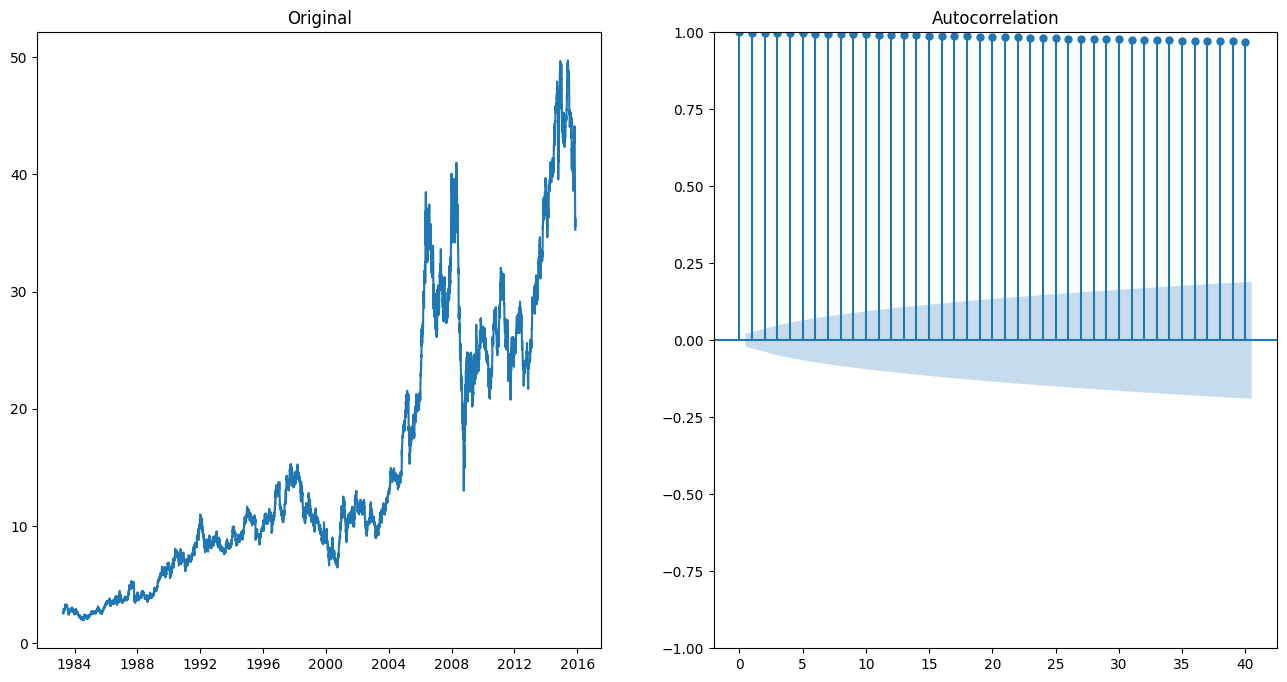

In [21]:
#Plot ACF
plotACF(adm_closing_prices, "Original")

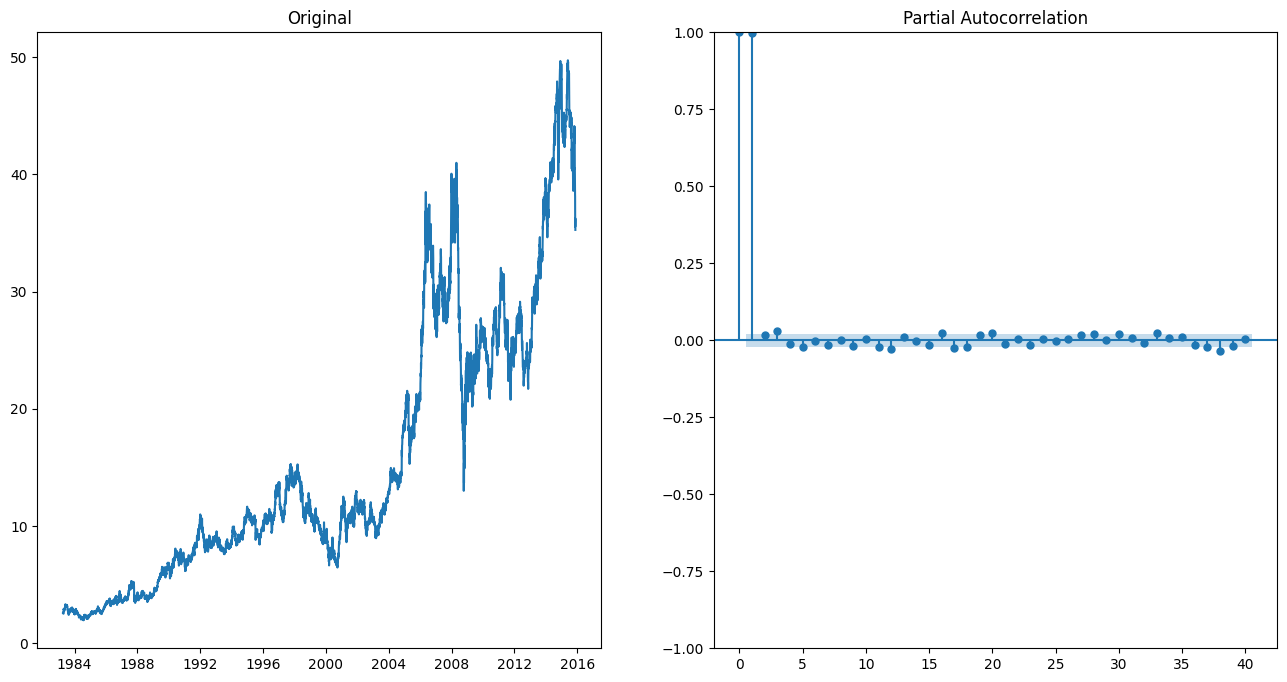

In [22]:
#Plot PACF
plotPACF(adm_closing_prices, "Original")
#For adm, the ACF plot decays steadily while the PACF plot drops instantly.
#This implies that an AR model would be the best fit for the data.

In [23]:

# To standardize the differential we need to know how many need to be taken.
#Used to see how many differentials should be taken
diff_num = ndiffs(adm_closing_prices, test="adf")
print(f"Number of Diffrening to run in :{diff_num}")


def x_diffs(df_: pd.DataFrame, x: int) -> pd.DataFrame:
    if x == 0:
        return df_
    else:
        return x_diffs(df_.diff().dropna(), x - 1)




Number of Diffrening to run in :1


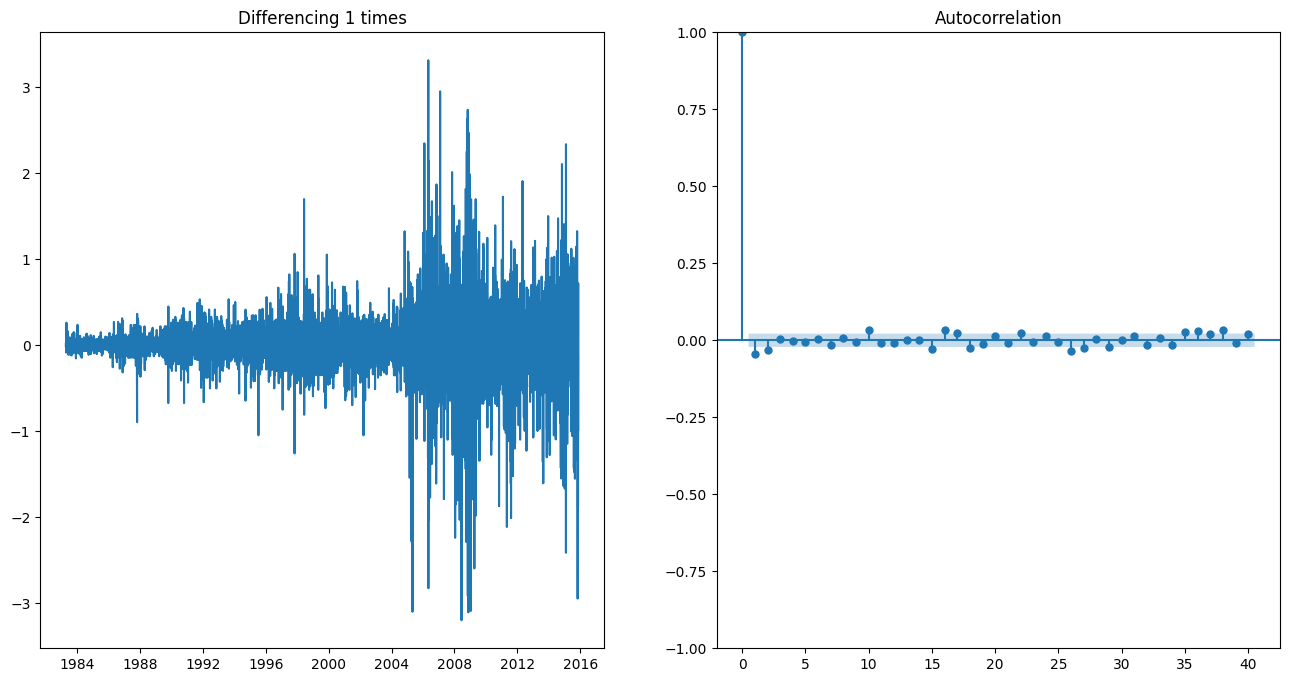

In [24]:
diff_x = x_diffs(adm_closing_prices,1)#Difference timeseries once

plotACF(diff_x, "Differencing 1 times") #Plot ACF of differenced timeseries


In [25]:
#Check stationary to see if it needs to be differenced again
checkStationary(diff_x) #Since P <0.05, diff_x is stationary


#Perform the same procedure for PACF
pdiff = adm_closing_prices.diff().dropna()

ADF statistic : -13.391347839429587
p-value: 4.7606402187290775e-25


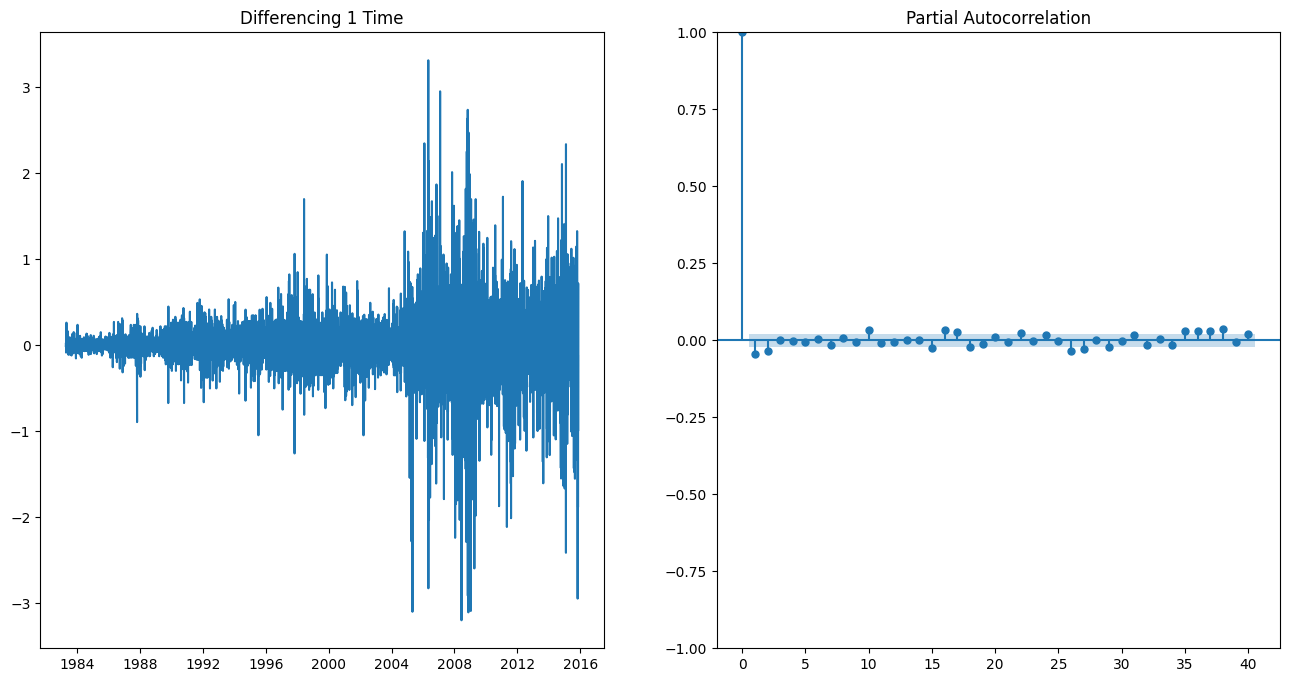

In [26]:
#Plot Partial Autocorrelation
plotPACF(pdiff, "Differencing 1 Time")

,Open,High,Low
Date,,,
1983-04-06,2.6112,2.6200,2.5771
1983-04-07,2.6200,2.6539,2.6200
1983-04-08,2.6368,2.6878,2.5944
1983-04-11,2.6200,2.6368,2.6112
1983-04-12,2.6112,2.6200,2.5771
...,...,...,...
2017-10-23,43.5000,43.6700,43.3800
2017-10-24,43.5950,43.9800,43.5400
2017-10-25,43.6000,43.6000,42.9000


#Optimal ARIMA Parameters

By the ACF and PCAF plots in the last section, the model that would fit the data the best would be an AR model, or a (p,0,0) ARIMA model.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9312.249, Time=10.42 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9316.635, Time=17.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9315.076, Time=16.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9311.117, Time=7.32 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-9316.747, Time=16.74 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-9315.698, Time=10.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-9314.378, Time=20.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9313.919, Time=19.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-9313.814, Time=11.65 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-9315.557, Time=9.40 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 140.254 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8226
Model:               SARIMAX(2, 0, 0)   Lo

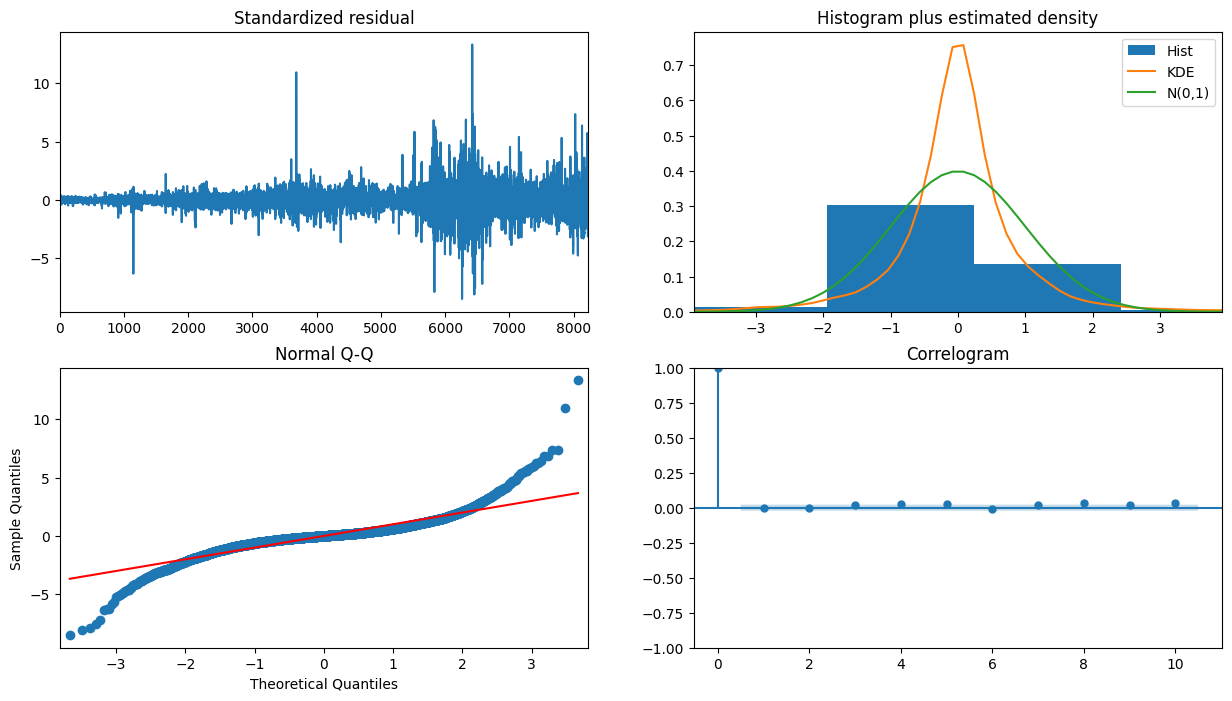

In [32]:



#Auto ARIMA to find optimal p, d, and q for ARIMA model.
#Finds optimal d by augmented Dickney-Fuller
#Does this by iterating between different values start_q, start_p and max_q, max_p until it finds the optimal combination.
#Says (1,0,0) is optimal (for 10 predictions)
#Says (2,0,0) is optimal (for 500 predictions)
#y=Data to predict
#X= exogeneous values that aid the training/testing


model_autoARIMA = auto_arima(y=adm_closing_prices,
                             X=exoDataframe,
                             start_p=0,
                             start_q=0,
                      test='adf', #Augmented Dickey-Fuller to "supposedly" find optimal d
                      max_p=3, max_q=3, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonality = False, #Time series is not seasonal
                      trace=True) #Shows which values it is trying
print(model_autoARIMA.summary())

#Show useful graphs
#Standardized residuals: Rediual = predicted-observed.  Show prediction errors occured at timesteps specified on x-axis
#Histogram: Graphs of histogram, standard normal, and KDE*
#QQ-Plot: Each residual becomes a quantile in a distrubution. This (y-axis) is plotted the quantiles for a normal distribution.
#The closer the points are to the red line, the closer the redisuals represnt a normal distribution.
# Correlogram is another way of saying autocorrelation plot.  This particular ACF is for the prediction residuals of the timeseries, not the time series itself.


#*:places a smaller normal distribution or other kernel around each point and adds up the areas, very similar to an idea of a continuious histogram.
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
adm_df['Close']


# Build Model

In [34]:
# Fit the ARIMA model
#Arima combines auto regessive model and moving average model while calculating differences in the time series to make it stationary.
# The parameters for ARIMA are (p, d, q)
# p: periods taken for autoregressive model
# d: Integrated order, difference -> number of differences taken for stationarity.
# q: periods in moving average model

model = ARIMA(adm_closing_prices, order=(2,0,0),exog=exoDataframe)  # Example parameters


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
#Fit model
result = model.fit()


In [36]:
#Print model summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8226
Model:                 ARIMA(2, 0, 0)   Log Likelihood                4665.383
Date:                Thu, 25 Apr 2024   AIC                          -9316.767
Time:                        19:22:06   BIC                          -9267.661
Sample:                             0   HQIC                         -9299.982
                               - 8226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.004      1.057      0.290      -0.004       0.013
Open          -0.5685      0.004   -137.959      0.000      -0.577      -0.560
High           0.7942      0.003    261.089      0.0

# Predictions

In [75]:
# Actual vs Fitted
#result.plot_predict(start = 1, end=60, dynamic=False,)
predValues = result.forecast(testSize, exog=adm_df[['Open', 'High', 'Low']].iloc[-testSize:].values)
print(predValues)
print(admTest)

pTest = pd.DataFrame(predValues)
pTest.set_index(admTest.index, inplace=True)


8226    35.363008
8227    34.710037
8228    34.155655
8229    34.811394
8230    34.094216
          ...    
8721    39.320563
8722    39.464419
8723    39.686692
8724    39.910755
8725    39.827119
Name: predicted_mean, Length: 500, dtype: float64
Date
2015-11-18    35.456
2015-11-19    34.528
2015-11-20    33.959
2015-11-23    34.802
2015-11-24    34.158
               ...  
2017-11-06    39.270
2017-11-07    39.540
2017-11-08    39.800
2017-11-09    39.600
2017-11-10    39.930
Name: Close, Length: 500, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import math
mse = mean_squared_error(admTest, predValues)
print('MSE: '+str(mse))
mae = mean_absolute_error(admTest, predValues)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(admTest, predValues))
print('RMSE: '+str(rmse))


r2 = r2_score(admTest, predValues)
print("R Squared: " + str(r2))



MSE: 0.04331081323347432
MAE: 0.159290862993533
RMSE: 0.20811250138680837
R Squared: 0.9972217072752609


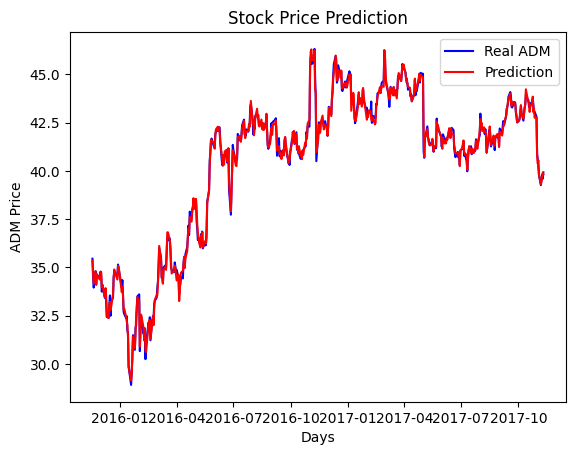

In [78]:
#Plot predictions


plt.plot(admTest, color = "blue", label = "Real ADM")
plt.plot(pTest, color = "red", label = "Prediction")
plt.title("Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("ADM Price")
plt.legend()
plt.show()

#Other Predictions

In [ ]:
##################################################################################################################################
#MSI model
print(msi_df)
MSImodel = ARIMA(msi_df['Close'], order=(0,0,0),exog=msi_df[['Open','High',"Low", "Volume"]])  # Example parameters

In [ ]:
resultMSI = MSImodel.fit()

In [ ]:
print(resultMSI.summary())

In [ ]:
predValues = resultMSI.forecast(10,exog=msi_df[['Open', 'High', 'Low', "Volume"]].iloc[-10:].values)
print(predValues)
print(msiTest)

In [ ]:
#Evaluation metrics

#Mean squared error
mse = mean_squared_error(msiTest, predValues)
print('MSE: '+str(mse))
#Mean absolute error
mae = mean_absolute_error(msiTest, predValues)
print('MAE: '+str(mae))
#Root mean squared
rmse = math.sqrt(mean_squared_error(msiTest, predValues))
print('RMSE: '+str(rmse))
r2 = r2_score(msiTest, predValues)
print("R Squared: " + str(r2))

In [ ]:
######################################################
#XOM model
print(xom_df)
XOMmodel = ARIMA(xom_df['Close'], order=(3, 1, 3),exog=xom_df[['Open','High',"Low", "Volume"]])

In [ ]:
resultXOM = XOMmodel.fit()
print(resultXOM.summary())

In [ ]:
predValues = resultXOM.forecast(10,exog=xom_df[['Open', 'High', 'Low', "Volume"]].iloc[-10:].values)
print(predValues)
print(xomTest)

In [ ]:
mse = mean_squared_error(xomTest, predValues)
print('MSE: '+str(mse))
mae = mean_absolute_error(xomTest, predValues)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(xomTest, predValues))
print('RMSE: '+str(rmse))
r2 = r2_score(xomTest, predValues)
print("R Squared: " + str(r2))
type(xomTest)

In [ ]:
from pmdarima import auto_arima

In [ ]:
model_autoARIMA = auto_arima(y=msi_df['Close'], X=msi_df[['Open', 'High', 'Low', 'Volume']], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model_autoARIMA = auto_arima(y=xom_df['Close'], X=xom_df[['Open', 'High', 'Low', 'Volume']], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()